In [11]:
# Ref: 4.7 建立堆疊的函式-StackingRegressor.ipynb

In [3]:
class StackingRegressor():

    def __init__(self, learners):
        # 接收基學習器、超學習器、以及堆疊中每一層分別有多少學習器
        # 複製學習器
        self.level_sizes = []
        self.learners = []
        for learning_level in learners:

            self.level_sizes.append(len(learning_level))
            level_learners = []
            for learner in learning_level:
                level_learners.append(deepcopy(learner))
            self.learners.append(level_learners)

    # fit 函式
    # 用第i-1層的基學習器預測值來訓練第i層的基學習器
    def fit(self, x, y):
        # 第1層基學習器的訓練資料即為原始資料
        meta_data = [x]
        meta_targets = [y]
        for i in range(len(self.learners)):
            level_size = self.level_sizes[i]

            # 建立第i層預測值的儲存空間
            data_z = np.zeros((level_size, len(x)))
            target_z = np.zeros(len(x))
            
            # 取得第i層訓練資料集
            train_x = meta_data[i]
            train_y = meta_targets[i]

            # 建立交叉驗證
            KF = KFold(n_splits=5)
            meta_index = 0
            for train_indices, test_indices in KF.split(x):
                for j in range(len(self.learners[i])):
                    # 使用前K-1折訓練第j個基學習器
                    learner = self.learners[i][j]
                    learner.fit(train_x[train_indices], train_y[train_indices])
                    # 使用第K折驗證第j個基學習器
                    predictions = learner.predict(train_x[test_indices])
                    # 儲存第K折第j個基學習器預測結果
                    data_z[j][meta_index:meta_index+len(test_indices)] = predictions

                target_z[meta_index:meta_index+len(test_indices)] = train_y[test_indices]
                meta_index += len(test_indices)

            # 儲存第i層基學習器的預測結果
            # 作為第i+1層基學習器的訓練資料
            data_z = data_z.transpose()
            meta_data.append(data_z)
            meta_targets.append(target_z)


            # 使用完整的訓練資料來訓練基學習器
            for learner in self.learners[i]:
                    learner.fit(train_x, train_y)

    # predict 函式
    def predict(self, x):

        # 儲存每一層的預測
        meta_data = [x]
        for i in range(len(self.learners)):
            level_size = self.level_sizes[i]

            data_z = np.zeros((level_size, len(x)))

            test_x = meta_data[i]


            for j in range(len(self.learners[i])):

                learner = self.learners[i][j]
                predictions = learner.predict(test_x)
                data_z[j] = predictions



            # 儲存第i層基學習器的預測結果
            # 作為第i+1層基學習器的輸入
            data_z = data_z.transpose()
            meta_data.append(data_z)

        # 傳回預測結果
        return meta_data

In [4]:
def simulate(data, preds):
    # 常數與暫存變數
    buy_threshold = 0.5
    stake = 100

    true, pred, balances = [], [], []

    buy_price = 0
    buy_points, sell_points = [], []
    balance = 0

    start_index = len(data) - len(preds) - 1

    # 計算預測值
    for i in range(len(preds)):
        # 昨日收盤價
        last_close = data.Close[i+start_index-1]
        # 今日收盤價
        current_close = data.Close[i+start_index]

        # 儲存今日收盤價
        true.append(current_close)
        # 儲存今日預測收盤價
        # 使用昨日收盤價跟模型預測的變化百分比換算而得
        pred.append(last_close*(1+preds[i]/100))


        # 根據預測進行交易
        # 預測會漲價並且手上沒有比特幣
        if preds[i] > buy_threshold and buy_price == 0:
            buy_price = true[-1]
            buy_points.append(i)

        # 預測會下跌且手上持有比特幣
        elif preds[i] < -buy_threshold and not buy_price == 0:
            profit = (current_close - buy_price) * stake / buy_price
            balance += profit
            buy_price = 0
            sell_points.append(i)

        balances.append(balance)


    true = np.array(true)
    pred = np.array(pred)

    # 繪製圖表
    plt.figure(figsize = (8, 8))
    plt.scatter(buy_points, true[buy_points]+500, 
                marker='x', label = "buy")
    plt.scatter(sell_points, true[sell_points]-500, 
                marker='o', label = "sell", s = 5)
    plt.plot(true, label = 'True', c = 'red')
    plt.plot(pred, label = 'pred', linestyle = '--', 
             c = 'black')
    plt.title('Trades')
    plt.legend()
    plt.show()

    plt.figure(figsize = (8, 8))
    plt.plot(balances)
    plt.title('Profit')
    plt.show()
    print('MSE: %.2f'%metrics.mean_squared_error(true, pred))
    balance_df = pd.DataFrame(balances)

    pct_returns = balance_df.diff()/stake
    pct_returns = pct_returns[pct_returns != 0].dropna()


    print('Sharpe: %.2f'%(np.mean(pct_returns)/np.std(pct_returns)))

In [5]:
def create_x_data(lags=1):
    diff_data = np.zeros((diff_len, lags))

    for lag in range(1, lags+1):
        this_data = diffs[:-lag]
        diff_data[lag:, lag-1] = this_data

    return  diff_data

In [6]:
# 第 1 部分
# 載入函式庫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from copy import deepcopy

# 載入資料集
np.random.seed(123456)
data = pd.read_csv('../Data/BTC-USD.csv')

# 特徵工程
# 刪除資料中的缺失值
data = data.dropna()
# 將UTC時間轉成年月日
data['Date'] = pd.to_datetime(data['Date'])
# 將時間設定為索引
data.set_index('Date', drop=True, inplace=True)
diffs = (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values[1:]
diff_len = len(diffs)

In [7]:
# 第 2 部分
# 建立模型
base_learners = [[SVR(), 
                  LinearRegression(), 
                  KNeighborsRegressor()], 
                 [LinearRegression()]]
lr = StackingRegressor(base_learners)


In [8]:
# 第 3 部分
# 建立特徵
x_data = create_x_data(lags = 20) * 100
y_data = diffs * 100


x_data = np.around(x_data, decimals = 8)
y_data = np.around(y_data, decimals = 8)

Percentages MSE: 15.24


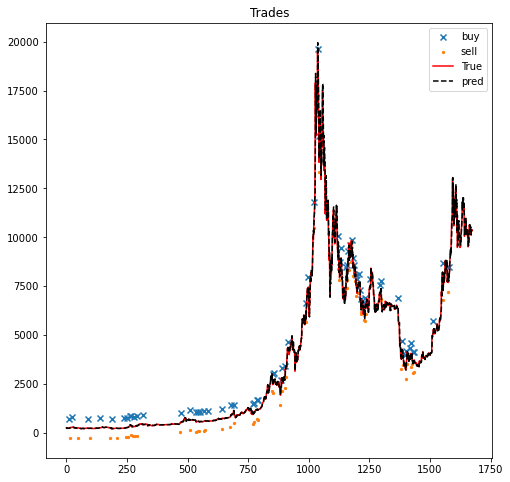

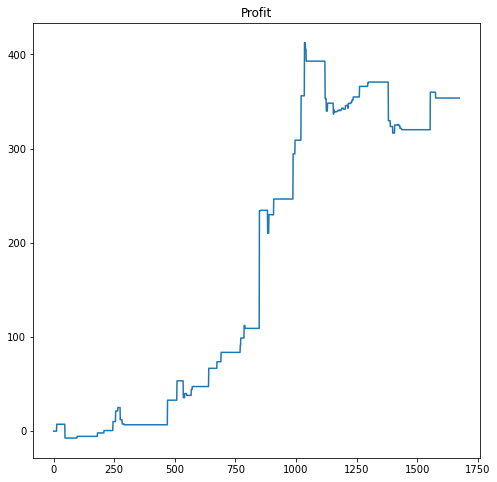

MSE: 91062.64
Sharpe: 0.24


In [9]:
# 第 4 部分
# 訓練模型
window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))[-1]

print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)

Percentages MSE: 15.08


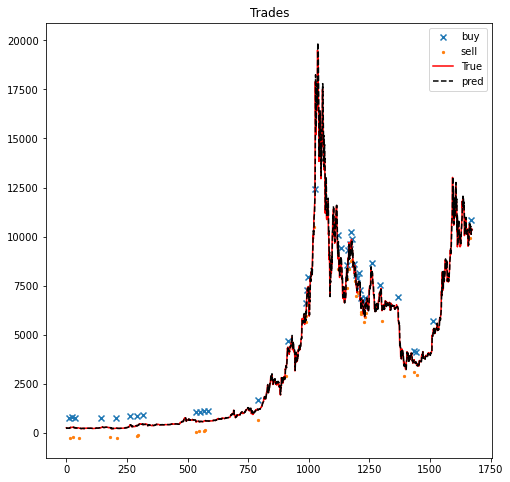

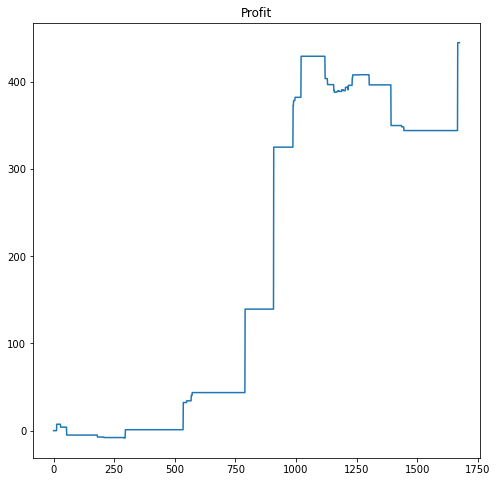

MSE: 91210.02
Sharpe: 0.29


In [10]:
# 第 5 部分
# 改進模型:移除線性迴歸基學習器，重新訓練堆疊模型
base_learners = [[SVR(), 
                  KNeighborsRegressor()], 
                 [LinearRegression()]]
lr = StackingRegressor(base_learners)
# 訓練模型
window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))[-1]

print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)